In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import cuml
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import squidpy as sq
from matplotlib.colors import ListedColormap

In [3]:
from pipeline import (LoadCytAssistPipeline, IntegrateDatasetPipeline, \
        TrainModelPipeline, LoadVisiumPipeline, InferencePipeline)
from plotting import plot_latent

### Load annotation files

In [4]:
antibody_panel = pd.read_csv('../antibody_panel.csv')
adata_annot = sc.read_h5ad("../adata/tonsil_cytassist.h5ad")
data_path = '../data/TonsilTissue'

### Initialize dataloader pipelines

In [5]:
train_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    geneset=f'../data/Tonsil.txt',
    sample_id = 0,
    name = 'Tonsil 1',
    celltypes = adata_annot.obs.celltype
)

eval_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    geneset=f'../data/Tonsil.txt',
    sample_id = 1,
    name = 'Tonsil 2',
    celltypes = adata_annot.obs.celltype
)

test_loader = LoadVisiumPipeline(
    tissue='Tonsil', 
    visium_dir=data_path+'/GEX', 
    sample_id=2, 
    name='ST Only'
)

Created CytAssist data loader pipeline.
Created CytAssist data loader pipeline.
Created 10x Visium data loader pipeline.


### Load training and evaluation data

In [6]:
adata, pdata = train_loader.run() ## fresh copy of training data
adata_eval, pdata_eval = eval_loader.run() ## fresh copy of eval data
adata, adata_eval = IntegrateDatasetPipeline('Tonsil', adata, adata_eval).run() ## integrate

Created data integration pipeline.


### Train SPICESS model

In [10]:
trainer = TrainModelPipeline(
    tissue = 'Tonsil',
    adata = adata,
    pdata = pdata,
    adata_eval = adata_eval,
    pdata_eval = pdata_eval,
    lr = 1e-3,
    patience = 1000,
    epochs = 10000,
)

In [11]:
spicess = trainer.run()

torch.Size([4194, 16]) torch.Size([4194, 30]) torch.Size([4908, 16]) torch.Size([4908, 30])


Imputation: 0.681 || Alignment: 0.502% | Loss: 0.00158:  75%|███████▌  | 4126/5500 [08:40<02:53,  7.93it/s, es-counter=200]


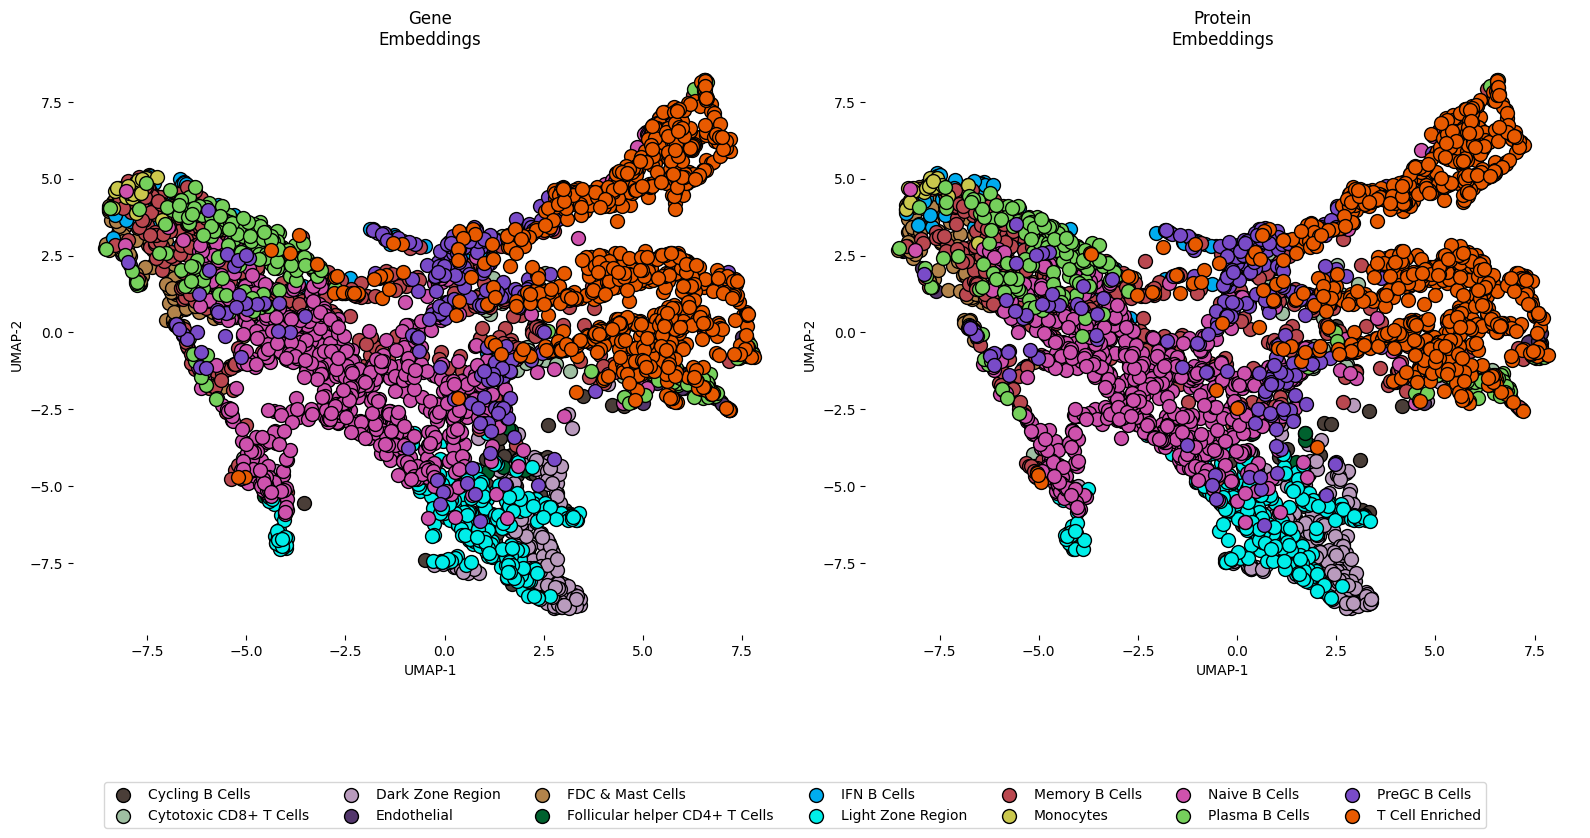

In [12]:
integrated_data =  spicess.model(X=[spicess.d11, spicess.d12], A=spicess.A)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()
refLabels = adata.obs.celltypes.values #cell2location labels
a, b = plot_latent([gex_z, pex_z], [refLabels, refLabels], 
    legend=True, method='umap',
    separate_dim=False, n_neighbors=200)

### Inference Pipeline

In [7]:
infer = InferencePipeline('../model_zoo/config_Tonsil_2023_10_02_22_19.yaml')

Created inference pipeline.


In [8]:
adata_test = test_loader.run()
gc_pth = 'https://raw.githubusercontent.com/vitkl/cell2location_paper/master/notebooks/selected_results/lymph_nodes_analysis/manual_GC_annot.csv'
df = pd.read_csv(gc_pth).fillna('Other')
df.columns = ['Barcode', 'spot_type']
adata_test.obs = adata_test.obs.join(df.set_index('Barcode'))

In [9]:
_, adata_test = IntegrateDatasetPipeline('Tonsil', adata, adata_test).run()

Created data integration pipeline.


In [10]:
pdata_pred = infer.run(adata_test.copy())

... storing 'spot_type' as categorical


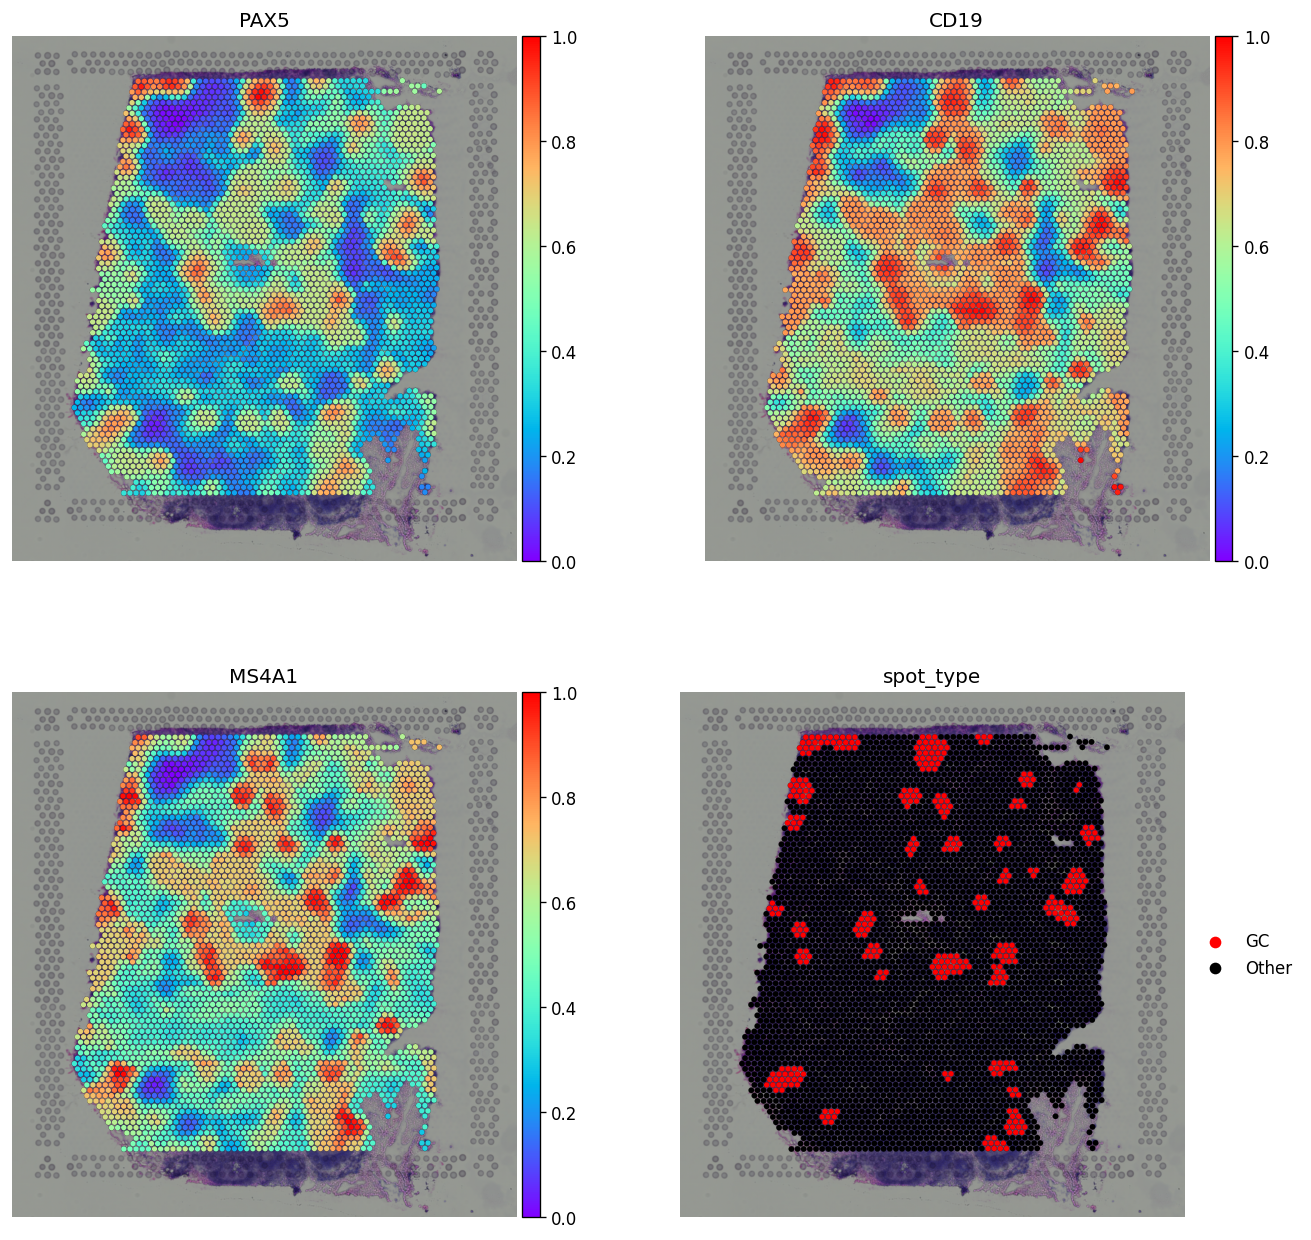

In [11]:
sq.pl.spatial_scatter(pdata_pred, 
    color=['PAX5', 'CD19', 'MS4A1', 'spot_type'], dpi=120, size=1.4, frameon=False, cmap='rainbow', ncols=2,
    figsize=(6, 6), edgecolor='black', linewidth=0.1, palette=ListedColormap(sns.color_palette(['red', 'black'])))

In [35]:
pdata_pred

AnnData object with n_obs × n_vars = 4035 × 30
    obs: 'source', 'domain_id', 'celltypes', 'batch', 'in_tissue', 'array_row', 'array_col', 'spot_type'
    uns: 'spatial', 'spot_type_colors'
    obsm: 'spatial'

In [31]:
a, b = plot_latent([gex_z, pex_z], [refLabels, refLabels], 
    legend=True, method='umap',
    separate_dim=False, n_neighbors=200)

NameError: name 'gex_z' is not defined